## Downloading the data

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rmcguinn","key":"a2bf522b0978ccc21f7ec3bd7c8fd022"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 99% 802M/812M [00:04<00:00, 236MB/s]
100% 812M/812M [00:04<00:00, 208MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

**Copying images to training, validation, and test directories**

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name: str, start_index: int, end_index: int) -> None:
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
            

make_subset("test", start_index=0, end_index=500)
make_subset("validation", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=2000)

**Using `image_dataset_from_directory` to read images**

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


# Training a convnet from scratch

## Using a small sample size

### Using an unregularized model

**Instantiating a small convnet for dogs vs. cats classification**

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Fitting the model using a `Dataset`**

In [9]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 20s 123ms/step - loss: 0.7004 - accuracy: 0.5285 - val_loss: 0.6912 - val_accuracy: 0.5750
Epoch 2/30
63/63 [==============================] - 7s 111ms/step - loss: 0.6944 - accuracy: 0.5870 - val_loss: 0.6706 - val_accuracy: 0.5920
Epoch 3/30
63/63 [==============================] - 7s 112ms/step - loss: 0.6703 - accuracy: 0.6155 - val_loss: 0.6377 - val_accuracy: 0.6320
Epoch 4/30
63/63 [==============================] - 7s 113ms/step - loss: 0.6361 - accuracy: 0.6480 - val_loss: 0.7505 - val_accuracy: 0.6080
Epoch 5/30
63/63 [==============================] - 7s 112ms/step - loss: 0.6036 - accuracy: 0.6800 - val_loss: 0.7940 - val_accuracy: 0.6180
Epoch 6/30
63/63 [==============================] - 7s 112ms/step - loss: 0.5712 - accuracy: 0.7105 - val_loss: 0.5894 - val_accuracy: 0.6910
Epoch 7/30
63/63 [==============================] - 7s 112ms/step - loss: 0.5328 - accuracy: 0.7325 - val_loss: 0.6315 - val_accuracy: 0.6570
Epoch

**Displaying curves of loss and accuracy during training**

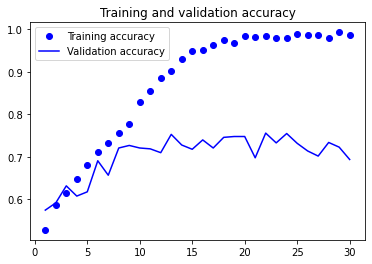

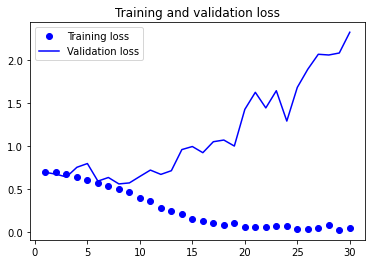

In [10]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [11]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 46ms/step - loss: 0.5283 - accuracy: 0.7460
Test accuracy: 0.746


### Using dropout

**Defining a new convnet that includes dropout**

In [12]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 9s 114ms/step - loss: 0.7285 - accuracy: 0.5230 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 7s 111ms/step - loss: 0.6995 - accuracy: 0.5250 - val_loss: 0.6864 - val_accuracy: 0.5310
Epoch 3/30
63/63 [==============================] - 7s 111ms/step - loss: 0.6913 - accuracy: 0.5395 - val_loss: 1.0863 - val_accuracy: 0.4990
Epoch 4/30
63/63 [==============================] - 7s 112ms/step - loss: 0.6767 - accuracy: 0.5925 - val_loss: 0.6685 - val_accuracy: 0.6040
Epoch 5/30
63/63 [==============================] - 7s 110ms/step - loss: 0.6530 - accuracy: 0.6275 - val_loss: 0.6521 - val_accuracy: 0.6450
Epoch 6/30
63/63 [==============================] - 7s 111ms/step - loss: 0.6395 - accuracy: 0.6460 - val_loss: 0.6269 - val_accuracy: 0.6680
Epoch 7/30
63/63 [==============================] - 7s 110ms/step - loss: 0.5889 - accuracy: 0.6900 - val_loss: 0.6520 - val_accuracy: 0.6670
Epoch 

**Evaluating the model on the test set**

In [14]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 48ms/step - loss: 0.5478 - accuracy: 0.7420
Test accuracy: 0.742


### Using image augmentation

**Define a data augmentation stage to add to an image model**

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Defining a new convnet that includes image augmentation**

In [17]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=60,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/60
63/63 [==============================] - 10s 121ms/step - loss: 0.8457 - accuracy: 0.5135 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 2/60
63/63 [==============================] - 8s 117ms/step - loss: 0.7047 - accuracy: 0.5040 - val_loss: 0.6940 - val_accuracy: 0.5130
Epoch 3/60
63/63 [==============================] - 8s 117ms/step - loss: 0.7005 - accuracy: 0.5665 - val_loss: 0.6859 - val_accuracy: 0.5470
Epoch 4/60
63/63 [==============================] - 8s 117ms/step - loss: 0.6888 - accuracy: 0.5855 - val_loss: 0.6529 - val_accuracy: 0.6040
Epoch 5/60
63/63 [==============================] - 8s 117ms/step - loss: 0.6614 - accuracy: 0.6175 - val_loss: 0.6688 - val_accuracy: 0.6150
Epoch 6/60
63/63 [==============================] - 8s 118ms/step - loss: 0.6693 - accuracy: 0.6020 - val_loss: 0.6320 - val_accuracy: 0.6630
Epoch 7/60
63/63 [==============================] - 8s 116ms/step - loss: 0.6279 - accuracy: 0.6595 - val_loss: 0.7701 - val_accuracy: 0.6050
Epoch

**Evaluating the model on the test set**

In [19]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 48ms/step - loss: 0.4591 - accuracy: 0.8120
Test accuracy: 0.812


### Using data augmentation with dropout

**Define a data augmentation stage to add to an image model**

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Defining a new convnet that includes image augmentation and dropout**

In [21]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 9s 119ms/step - loss: 0.7109 - accuracy: 0.5210 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 8s 117ms/step - loss: 0.7252 - accuracy: 0.5215 - val_loss: 0.6921 - val_accuracy: 0.5100
Epoch 3/100
63/63 [==============================] - 8s 117ms/step - loss: 0.6846 - accuracy: 0.5740 - val_loss: 0.6853 - val_accuracy: 0.5190
Epoch 4/100
63/63 [==============================] - 8s 118ms/step - loss: 0.7039 - accuracy: 0.5990 - val_loss: 0.6528 - val_accuracy: 0.6230
Epoch 5/100
63/63 [==============================] - 8s 118ms/step - loss: 0.6597 - accuracy: 0.6070 - val_loss: 0.6492 - val_accuracy: 0.6180
Epoch 6/100
63/63 [==============================] - 8s 120ms/step - loss: 0.6664 - accuracy: 0.6215 - val_loss: 0.6336 - val_accuracy: 0.6310
Epoch 7/100
63/63 [==============================] - 8s 117ms/step - loss: 0.6401 - accuracy: 0.6320 - val_loss: 0.6774 - val_accuracy: 0.6020

**Evaluating the model on the test set**

In [23]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 48ms/step - loss: 0.4097 - accuracy: 0.8090
Test accuracy: 0.809


## Increasing the training sample size

###Doubling sample size from 1000 to 2000

In [24]:
make_subset("train_2", start_index=1000, end_index=3000)

train_2_dataset = image_dataset_from_directory(
    new_base_dir / "train_2",
    image_size=(180, 180),
    batch_size=32)

Found 4000 files belonging to 2 classes.


### Building and evaluating model with image augmentation and dropout

**Defining a new convnet that includes image augmentation and dropout**

In [25]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_2000_samples.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_2_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
125/125 [==============================] - 15s 106ms/step - loss: 0.7141 - accuracy: 0.5400 - val_loss: 0.6826 - val_accuracy: 0.5130
Epoch 2/100
125/125 [==============================] - 13s 103ms/step - loss: 0.6770 - accuracy: 0.6020 - val_loss: 0.6852 - val_accuracy: 0.5610
Epoch 3/100
125/125 [==============================] - 13s 104ms/step - loss: 0.6598 - accuracy: 0.6170 - val_loss: 0.6353 - val_accuracy: 0.6520
Epoch 4/100
125/125 [==============================] - 13s 104ms/step - loss: 0.6431 - accuracy: 0.6435 - val_loss: 0.6694 - val_accuracy: 0.6110
Epoch 5/100
125/125 [==============================] - 13s 104ms/step - loss: 0.6246 - accuracy: 0.6530 - val_loss: 0.5772 - val_accuracy: 0.7080
Epoch 6/100
125/125 [==============================] - 13s 104ms/step - loss: 0.6242 - accuracy: 0.6643 - val_loss: 0.6139 - val_accuracy: 0.6830
Epoch 7/100
125/125 [==============================] - 13s 104ms/step - loss: 0.6044 - accuracy: 0.6785 - val_loss: 0.5679 -

**Evaluating the model on the test set**

In [27]:
test_model = keras.models.load_model(
    "convnet_from_scratch_2000_samples.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 50ms/step - loss: 0.2817 - accuracy: 0.8790
Test accuracy: 0.879


## Further increasing training sample size

###Increasing sample size to 10000

In [28]:
make_subset("train_3", start_index=1000, end_index=11000)

train_3_dataset = image_dataset_from_directory(
    new_base_dir / "train_3",
    image_size=(180, 180),
    batch_size=32)

Found 20000 files belonging to 2 classes.


### Building and evaluating model with image augmentation and dropout

**Defining a new convnet that includes image augmentation and dropout**

In [29]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_10000_samples.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_3_dataset,
    epochs=70,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/70
625/625 [==============================] - 62s 95ms/step - loss: 0.6749 - accuracy: 0.6044 - val_loss: 0.5635 - val_accuracy: 0.7300
Epoch 2/70
625/625 [==============================] - 59s 95ms/step - loss: 0.5622 - accuracy: 0.7092 - val_loss: 0.4954 - val_accuracy: 0.7610
Epoch 3/70
625/625 [==============================] - 59s 94ms/step - loss: 0.4963 - accuracy: 0.7642 - val_loss: 0.4068 - val_accuracy: 0.8080
Epoch 4/70
625/625 [==============================] - 59s 93ms/step - loss: 0.4498 - accuracy: 0.7889 - val_loss: 0.3636 - val_accuracy: 0.8330
Epoch 5/70
625/625 [==============================] - 58s 93ms/step - loss: 0.4017 - accuracy: 0.8188 - val_loss: 0.4810 - val_accuracy: 0.7710
Epoch 6/70
625/625 [==============================] - 58s 92ms/step - loss: 0.3697 - accuracy: 0.8367 - val_loss: 0.2844 - val_accuracy: 0.8720
Epoch 7/70
625/625 [==============================] - 58s 92ms/step - loss: 0.3504 - accuracy: 0.8476 - val_loss: 0.2798 - val_accuracy:

**Evaluating the model on the test set**

In [31]:
test_model = keras.models.load_model(
    "convnet_from_scratch_10000_samples.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 50ms/step - loss: 0.2467 - accuracy: 0.8990
Test accuracy: 0.899


# Leveraging a pretrained model with Fine Tuning

## Using a small sample size

**Instantiating the VGG16 convolutional base**

In [32]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58900480/58889256 [==============================] - 1s 0us/step


**Instantiating and freezing the VGG16 convolutional base**

In [33]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# Freeze all but last four layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Adding a data augmentation stage and a classifier to the convolutional base and fine tuning**

In [34]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_1000_samples.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 30s 399ms/step - loss: 2.9432 - accuracy: 0.7885 - val_loss: 0.7741 - val_accuracy: 0.9160
Epoch 2/30
63/63 [==============================] - 23s 360ms/step - loss: 1.0372 - accuracy: 0.8890 - val_loss: 0.3983 - val_accuracy: 0.9430
Epoch 3/30
63/63 [==============================] - 23s 360ms/step - loss: 0.6886 - accuracy: 0.9070 - val_loss: 0.3178 - val_accuracy: 0.9540
Epoch 4/30
63/63 [==============================] - 23s 359ms/step - loss: 0.4133 - accuracy: 0.9310 - val_loss: 0.2519 - val_accuracy: 0.9570
Epoch 5/30
63/63 [==============================] - 23s 362ms/step - loss: 0.3141 - accuracy: 0.9430 - val_loss: 0.2132 - val_accuracy: 0.9620
Epoch 6/30
63/63 [==============================] - 23s 360ms/step - loss: 0.2033 - accuracy: 0.9490 - val_loss: 0.1901 - val_accuracy: 0.9600
Epoch 7/30
63/63 [==============================] - 23s 354ms/step - loss: 0.1625 - accuracy: 0.9590 - val_loss: 0.2281 - val_accuracy: 0.9630

In [35]:
model = keras.models.load_model("fine_tuning_1000_samples.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 7s 207ms/step - loss: 0.1842 - accuracy: 0.9720
Test accuracy: 0.972


## Increasing training sample size

**Instantiating the VGG16 convolutional base**

In [36]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

**Instantiating and freezing the VGG16 convolutional base**

In [37]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# Freeze all but last four layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Adding a data augmentation stage and a classifier to the convolutional base and fine tuning**

In [38]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_2000_samples.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_2_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
125/125 [==============================] - 40s 303ms/step - loss: 2.7086 - accuracy: 0.8055 - val_loss: 0.5192 - val_accuracy: 0.9450
Epoch 2/30
125/125 [==============================] - 38s 303ms/step - loss: 0.5542 - accuracy: 0.9155 - val_loss: 0.3109 - val_accuracy: 0.9600
Epoch 3/30
125/125 [==============================] - 38s 303ms/step - loss: 0.3550 - accuracy: 0.9237 - val_loss: 0.2043 - val_accuracy: 0.9690
Epoch 4/30
125/125 [==============================] - 38s 303ms/step - loss: 0.2063 - accuracy: 0.9423 - val_loss: 0.1849 - val_accuracy: 0.9690
Epoch 5/30
125/125 [==============================] - 38s 303ms/step - loss: 0.1588 - accuracy: 0.9523 - val_loss: 0.1638 - val_accuracy: 0.9760
Epoch 6/30
125/125 [==============================] - 38s 300ms/step - loss: 0.1531 - accuracy: 0.9575 - val_loss: 0.1860 - val_accuracy: 0.9680
Epoch 7/30
125/125 [==============================] - 38s 303ms/step - loss: 0.1335 - accuracy: 0.9575 - val_loss: 0.1552 - val_ac

In [39]:
model = keras.models.load_model("fine_tuning_2000_samples.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 7s 207ms/step - loss: 0.1877 - accuracy: 0.9780
Test accuracy: 0.978


## Further increasing training sample size

**Instantiating the VGG16 convolutional base**

In [40]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

**Instantiating and freezing the VGG16 convolutional base**

In [41]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# Freeze all but last four layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Adding a data augmentation stage and a classifier to the convolutional base and fine tuning**

In [42]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning_10000_samples.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_3_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
625/625 [==============================] - 163s 257ms/step - loss: 0.8207 - accuracy: 0.8939 - val_loss: 0.1033 - val_accuracy: 0.9690
Epoch 2/30
625/625 [==============================] - 161s 257ms/step - loss: 0.1503 - accuracy: 0.9489 - val_loss: 0.0899 - val_accuracy: 0.9720
Epoch 3/30
625/625 [==============================] - 160s 256ms/step - loss: 0.1074 - accuracy: 0.9639 - val_loss: 0.1100 - val_accuracy: 0.9800
Epoch 4/30
625/625 [==============================] - 160s 256ms/step - loss: 0.0999 - accuracy: 0.9686 - val_loss: 0.1379 - val_accuracy: 0.9780
Epoch 5/30
625/625 [==============================] - 160s 256ms/step - loss: 0.0878 - accuracy: 0.9710 - val_loss: 0.1813 - val_accuracy: 0.9820
Epoch 6/30
625/625 [==============================] - 161s 256ms/step - loss: 0.0854 - accuracy: 0.9712 - val_loss: 0.1688 - val_accuracy: 0.9800
Epoch 7/30
625/625 [==============================] - 160s 256ms/step - loss: 0.0807 - accuracy: 0.9759 - val_loss: 0.1729 -

In [43]:
model = keras.models.load_model("fine_tuning_10000_samples.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 7s 208ms/step - loss: 0.0777 - accuracy: 0.9720
Test accuracy: 0.972
